In [102]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.integrate import quad
import random
import pandas as pd
from sympy import Symbol,integrate,exp,cos,sin,I,simplify
import seaborn as sns

/var/folders/0j/pvk96pnn2pn8tkgvkktcydbh0000gn/T/ipykernel_99581/1891499008.py:137: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Z0 = np.trapz(B0, xx); Z1 = np.trapz(B0bar, xx)


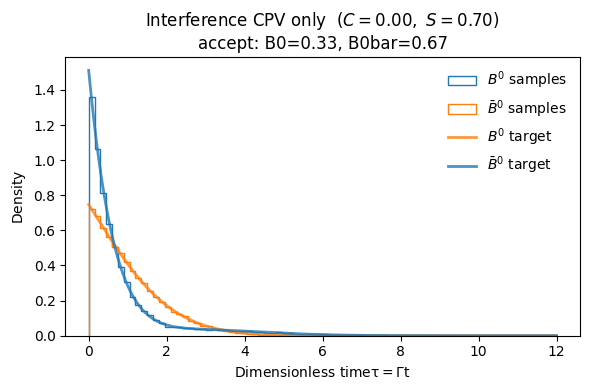

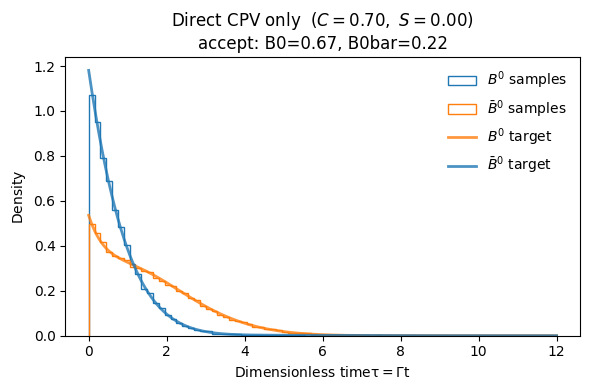

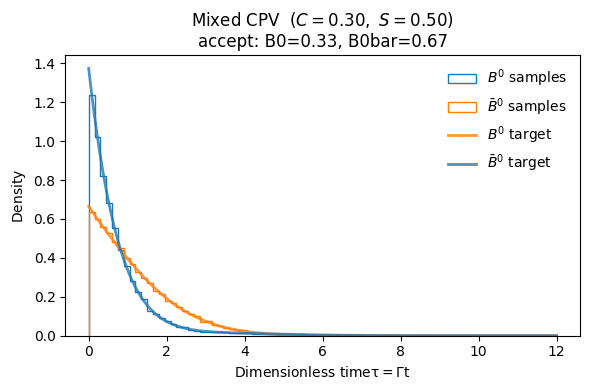

In [103]:
x_grid = np.linspace(0, 12, 30000)  # ps (for plotting/reference)
Gamma = 0.658  # ps^{-1} (1/tau_Bd with tau~1.52 ps)
Delta_m = 0.506  # ps^{-1}
r= Delta_m/Gamma

def rates(C, S, x):
    """
    Return (B0, B0bar) rates vs time for given (C,S) on grid t.
    Unnormalized; proportional to the differential decay rate.
    """
    base = np.exp(-x)
    osc = np.cos(r * x)
    sin = np.sin(r * x)
    B0    = base * (1 - C * osc + S * sin)
    B0bar = base * (1 + C * osc - S * sin)
    return B0, B0bar


# --- Sampling utilities ---
def _trunc_exp_rvs(n, x_max, rng):
    """
    Draw n samples from Exp(Gamma) truncated to [0, t_max].
    Inverse-CDF sampling for stability.
    """
    u = rng.random(n)
    Z = 1.0 - np.exp(-x_max)  # truncation norm
    return -np.log(1.0 - Z * u) 


def _modulation(x, C, S, tag):
    """
    Modulating factor 1 + tag*(S*sin(Δm t) - C*cos(Δm t)).
    (tag = +1 for \bar{B}^0, tag = -1 for B^0 in the convention used here)
    """
    return 1.0 + tag * (S * np.sin(r * x) - C * np.cos(r * x))


def _pmax_bound(C, S):
    """
    A tight, t-independent upper bound on the modulation.
    For any t, max over tag in {±1} of [1 + tag*(S*sin - C*cos)] <= 1 + sqrt(C^2 + S^2).
    """
    return 1.0 + np.hypot(C, S)


def sample_tagged_times(n, C, S, tag, x_max, rng=None):
    """
    Rejection sample n proper times for a given flavor tag from the
    time-dependent rate  ~  e^{-Gamma t} * [1 + tag*(S*sin(Δm t) - C*cos(Δm t))]
    restricted to t in [0, t_max].

    Parameters
    ----------
    n : int
        Number of samples to return.
    C, S : float
        Direct/interference CPV coefficients.
    tag : int
        +1 for \bar{B}^0, -1 for B^0 (matches the 'rates' convention above).
    t_max : float
        Maximum proper time to sample (ps).
    rng : np.random.Generator or None
        Random generator; if None, uses default.

    Returns
    -------
    t : np.ndarray, shape (n,)
        Sampled proper times (ps).
    accept_rate : float
        Empirical acceptance rate of the rejection sampler.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Safety: if modulation dips below zero anywhere, the model is unphysical.
    # We still sample safely by clipping the modulation at zero inside rejection,
    # but warn the user.
    if 1.0 - np.hypot(C, S) < 0:
        # This can happen if |C|^2 + |S|^2 > 1 or large coefficients are provided.
        # We won't raise, but it's worth flagging upstream if needed.
        pass

    M = _pmax_bound(C, S)  # envelope on the modulation
    x_samples = np.empty(n, dtype=float)
    got = 0
    trials = 0
    batch = max(256, int(1.5 * n))  # vectorized batches for speed

    # Accept-reject loop
    while got < n:
        x_prop = _trunc_exp_rvs(batch, x_max, rng)  # proposal times from truncated exp
        w = _modulation(x_prop, C, S, tag)
        w = np.clip(w, 0.0, None)  # robust if user picks unphysical (C,S)
        u = rng.random(batch)
        print()
        keep = u < (w / M)  # rejection step relative to envelope
        n_keep = min(keep.sum(), n - got)
        if n_keep > 0:
            x_samples[got:got+n_keep] = x_prop[keep][:n_keep]
            got += n_keep
        trials += batch

    accept_rate = float(n) / float(trials)
    return x_samples, accept_rate


def sample_pair(n_B0, n_B0bar, C, S, x_max, seed=None):
    """
    Convenience wrapper: sample both B^0 and \bar{B}^0 time sets.

    Returns
    -------
    t_B0, t_B0bar, info
    """
    rng = np.random.default_rng(seed)
    # Our 'rates' convention used tag = -1 for B^0 and +1 for \bar{B}^0
    x_B0, acc0 = sample_tagged_times(n_B0, C, S, tag=-1, x_max=x_max, rng=rng)
    x_B0bar, acc1 = sample_tagged_times(n_B0bar, C, S, tag=+1, x_max=x_max, rng=rng)
    info = {"accept_rate_B0": acc0, "accept_rate_B0bar": acc1, "x_max": x_max}
    return x_B0, x_B0bar, info


def demo_sampling(cases, x_max, n_each=20000, seed=1234):
    """
    Plot histograms of sampled times overlaid with the target rate curves.
    'cases' is a list of (C, S, title).
    """
    rng = np.random.default_rng(seed)

    for (C, S, title) in cases:
        x_B0, acc0 = sample_tagged_times(n_each, C, S, tag=-1, x_max=x_max, rng=rng)
        x_B0bar, acc1 = sample_tagged_times(n_each, C, S, tag=+1, x_max=x_max, rng=rng)

        # Rates on plotting grid, normalized to unit area on [0,t_max]
        xx = x_grid[(x_grid >= 0) & (x_grid <= x_max)]
        B0, B0bar = rates(C, S, xx)
        Z0 = np.trapz(B0, xx); Z1 = np.trapz(B0bar, xx)
        B0n, B0barn = B0/Z0, B0bar/Z1
        #Cplot=(t_B0bar-t_B0)*np.exp(Gamma*tt)*np.cos(Delta_m*tt)
        
        fig, ax = plt.subplots(1, 1, figsize=(6,4))
        ax.hist(x_B0, bins=80, range=(0, x_max), density=True, histtype='step', label=r"$B^0$ samples", color = "tab:blue")
        ax.hist(x_B0bar, bins=80, range=(0, x_max), density=True, histtype='step', label=r"$\bar B^0$ samples", color = "tab:orange")
        ax.plot(xx, B0n, label=r"$B^0$ target", linewidth=2, alpha=0.8, color = "tab:orange")
        ax.plot(xx, B0barn, label=r"$\bar B^0$ target", linewidth=2, alpha=0.8, color = "tab:blue")
        #ax.plot(tt, Cplot, label=r"C Plot", linewidth=2, alpha=0.8, color = "tab:red")

        ax.set_xlabel(r"$\mathrm{Dimensionless\ time} \mathrm{\tau=\Gamma t}$")
        ax.set_ylabel(r"$\mathrm{Density}$")
        ax.set_title(title + rf"  $(C={C:.2f},\ S={S:.2f})$" + 
                     f"\naccept: B0={acc0:.2f}, B0bar={acc1:.2f}")
        ax.legend(frameon=False)
        fig.tight_layout()

# Example cases mirroring earlier plots
cases = [
    (0.0, 0.70, "Interference CPV only"),
    (0.70, 0.0, "Direct CPV only"),
    (0.30, 0.50, "Mixed CPV"),
]

demo_sampling(cases, n_each=30000, x_max=12.0, seed=42)

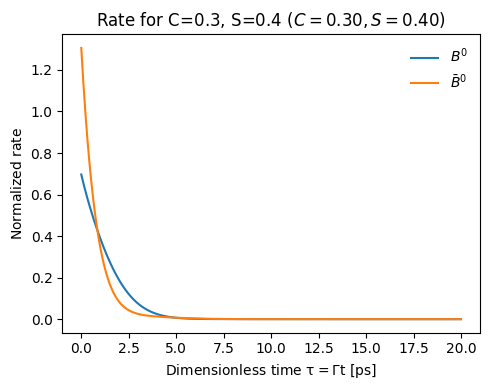

In [104]:
# Physical-ish parameters for B_d
Gamma = 0.658  # ps^{-1} (1/tau_Bd with tau~1.52 ps)
Delta_m = 0.506  # ps^{-1}
r= Delta_m/Gamma
t = np.linspace(0, 8, 8000)  # ps
x = np.linspace(0, 20, 20000)
x_max=12
x_grid = np.linspace(0, 8, 800)  # ps (for plotting/reference)
xx = x_grid[(x_grid >= 0) & (x_grid <= x_max)]
        
def rates(C, S):
    """
    Return (B0, B0bar) rates vs time for given (C,S).
    """
    base = np.exp(-x)
    cos  = np.cos(r * x)
    sin  = np.sin(r * x)
    #-cos(x) = cos(x - \pi) = cos(x)
    #-sin(x) = sin(x - \pi)
    B0    = base * (1 - C * cos + S * sin)
    B0bar = base * (1 + C * cos - S * sin)
    return B0, B0bar
    
def plot_case(C, S, title):
    B0, B0bar = rates(C, S)

    # Normalize for visibility so total areas are comparable
    B0   = B0 / np.trapezoid(B0, x)
    B0bar= B0bar / np.trapezoid(B0bar, x)

    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    ax.plot(x, B0, label=r"$B^0$")
    ax.plot(x, B0bar, label=r"$\bar B^0$")
    ax.set_xlabel(r"$\mathrm{Dimensionless\ time\ \tau=\Gamma t\ [ps]}$")
    ax.set_ylabel(r"$\mathrm{Normalized\ rate}$")
    ax.set_title(title + rf" $(C={C:.2f}, S={S:.2f})$")
    ax.legend(frameon = False)
    fig.tight_layout()
    
plot_case(0.3,0.4,"Rate for C=0.3, S=0.4")

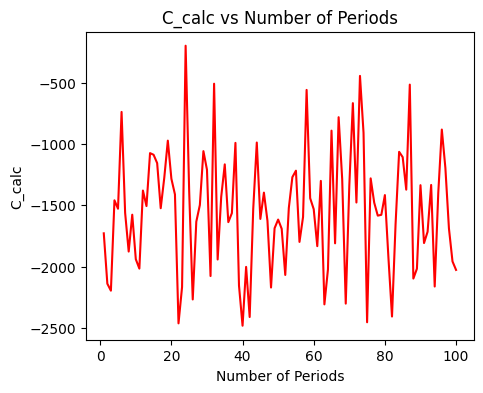

In [106]:
Gamma = 0.658  # ps^{-1} (1/tau_Bd with tau~1.52 ps)
Delta_m = 0.506  # ps^{-1}
r= Delta_m/Gamma
xunif = np.linspace(0, 12, 20000)
#t = np.linspace(0, 8, 100)  # ps
cases=np.linspace(1,100,100)
crange=np.linspace(0,1,100)


def monte(C,S):
    C_calc=np.array([])
    C_err=np.array([])
    numx=np.array([])
    x_max=12
    for i in cases:
        j=0
        #while j<5:
        n=20000
        x, acc = sample_tagged_times(n, C, S, -1, x_max, rng=None)
        xbar, accbar = sample_tagged_times(n, C, S, +1, x_max, rng=None)
        x=np.array(sorted(x))
        xbar=np.array(sorted(xbar))
            #x= Gamma*x
            #xbar=Gamma*xbar
        xunif = np.linspace(0, x_max, n)  # ps (for plotting/reference)
        xx = xunif[(xunif >= 0) & (xunif <= x_max)]
            #t = np.linspace(0, t_max, n)  # ps
        #base= np.exp(-x)
        #co  = np.cos(r*x)
        #si  = np.sin(r*x)
            #B0    = base * (1 - i * co + S * si)
            #B0bar = base * (1 + i * co - S * si)
        numx=np.append(numx,i)
        C_val=np.mean((xbar-x)*np.exp(xx)*np.cos(r*xx))
        C_calc=np.append(C_calc,C_val)
        C_err=np.append(C_err,C_val-C)
            #j+=1
    return numx, C_calc,C_err

numx, Cm, C_err=monte(0.3, 0.4)
fig, ax2 = plt.subplots(1, 1, figsize=(5,4))
sns.lineplot(x=numx, y=Cm, color='red')
plt.title('C_calc vs Number of Periods')
ax2.set_xlabel(r"Number of Periods")
ax2.set_ylabel(r"C_calc")
#plt.savefig("C values", bbox_inches='tight')
plt.show()

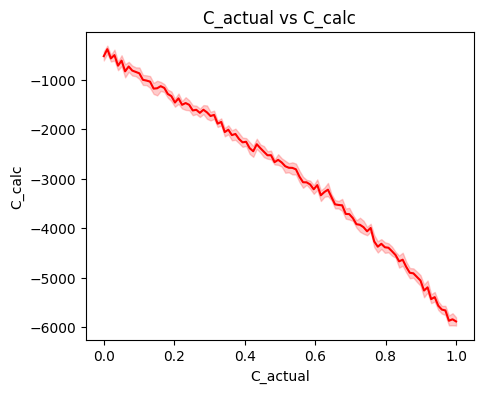

In [107]:
def Cerror(C,S):
    C_calc=np.array([])
    C_err=np.array([])
    numx=np.array([])
    x_max=12
    for i in crange:
        j=0
        for j in range(10):
            n=20000
            x, acc = sample_tagged_times(n, i, S, -1, x_max, rng=None)
            xbar, accbar = sample_tagged_times(n, i, S, +1, x_max, rng=None)
            xunif = np.linspace(0, x_max, n)  # ps (for plotting/reference)
            xx = xunif[(xunif >= 0) & (xunif <= x_max)]
            #t = np.linspace(0, t_max, n)  # ps
            base= np.exp(-x)
            co  = np.cos(r*x)
            si  = np.sin(r*x)
            #B0    = base * (1 - i * co + S * si)
            #B0bar = base * (1 + i * co - S * si)
            numx=np.append(numx,i)
            C_val=np.mean((xbar-x)*np.exp(xx)*np.cos(r*xx))
            C_calc=np.append(C_calc,C_val)
        #C_err=np.append(C_err,C_val-C)
    return numx, C_calc

numx, Cm, C_err=monte(0.3, 0.4)
cvals=np.linspace(0,1,5)
numCs, Cs = Cerror(0.3,0.4)
fig, ax2 = plt.subplots(1, 1, figsize=(5,4))
sns.lineplot(x=numCs, y=Cs, color='red')
plt.title('C_actual vs C_calc')
ax2.set_xlabel(r"C_actual")
ax2.set_ylabel(r"C_calc")
#plt.savefig("C values", bbox_inches='tight')
plt.show()

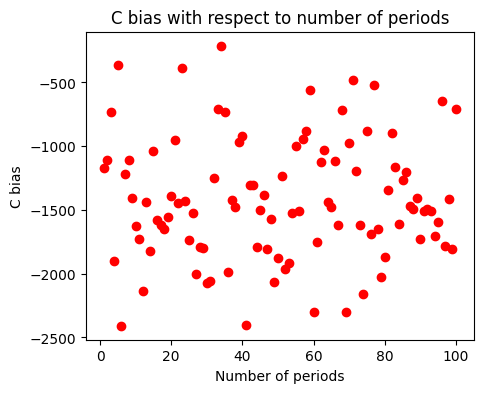

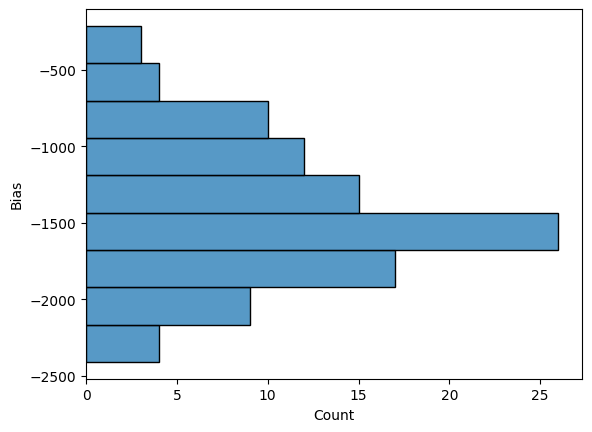

<Axes: xlabel='No. of Periods', ylabel='Bias'>

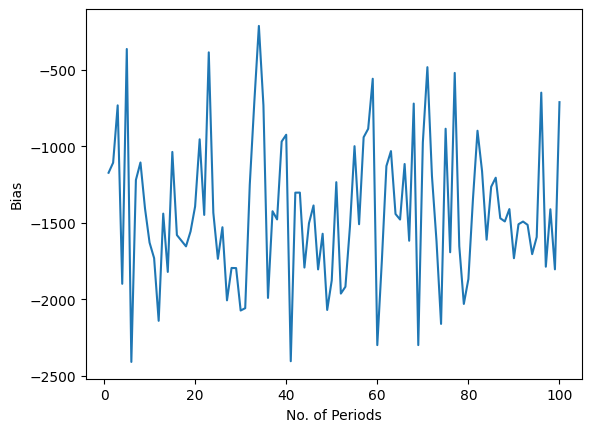

In [108]:
fig, ax2 = plt.subplots(1, 1, figsize=(5,4))
plt.scatter(x=numx, y=C_err, color='red')
plt.title('C bias with respect to number of periods')
ax2.set_xlabel(r"Number of periods")
ax2.set_ylabel(r"C bias")
#plt.savefig("C values", bbox_inches='tight')
plt.show()

error={'No. of Periods': numx, 'Bias':C_err}
errdf=pd.DataFrame(error)
sns.histplot(y='Bias', data=errdf)
plt.show()
sns.lineplot(x='No. of Periods', y='Bias', data=errdf, errorbar=("sd"))

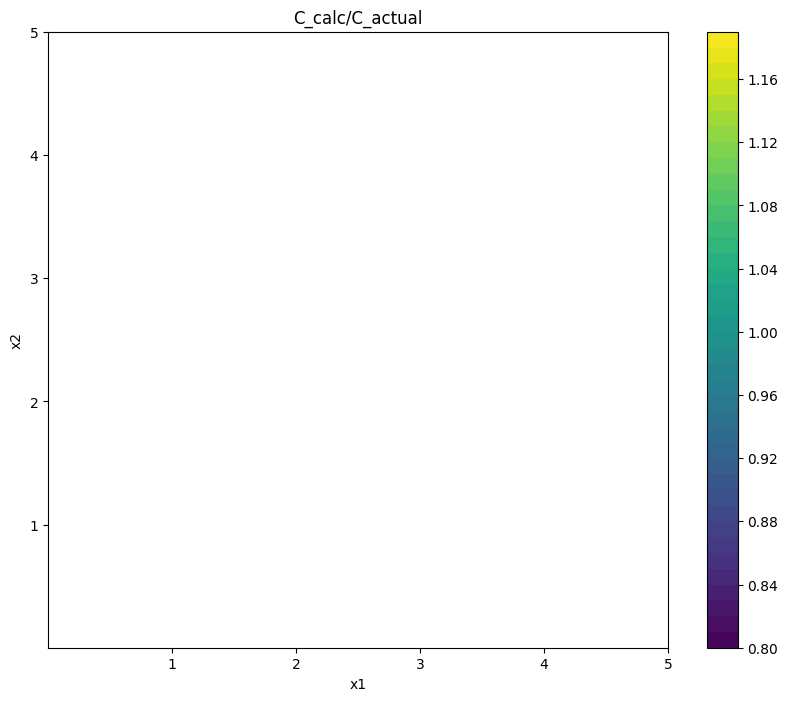

/usr/local/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


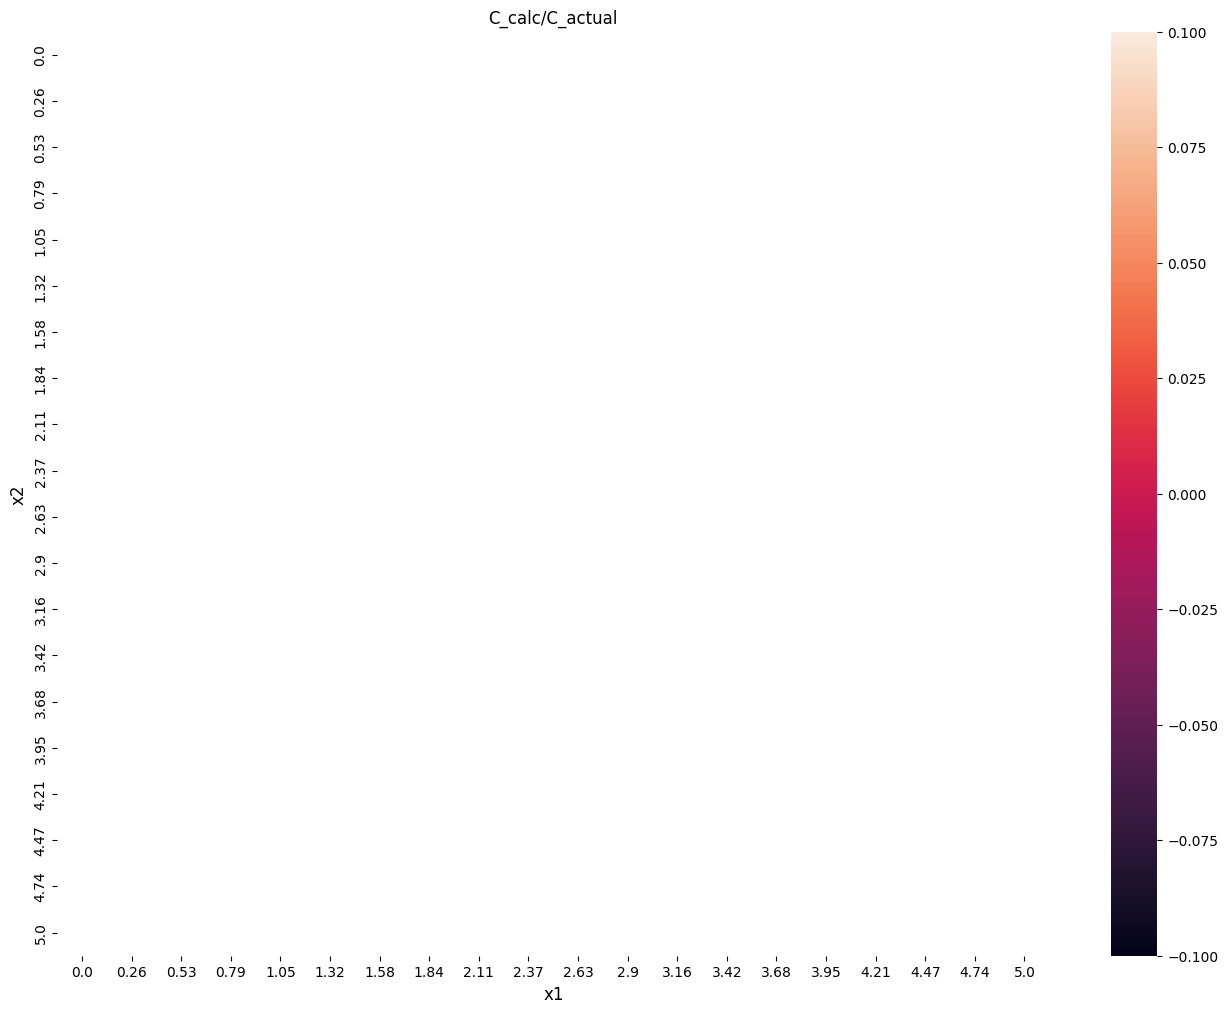

In [114]:
Gamma = 0.659  # ps^{-1} (1/tau_Bd with tau~1.52 ps)
Delta_m = 0.506  # ps^{-1}
period=8
#alpha = np.linspace(0, 8, 100)
#t = np.linspace(0, 8, 100)  # ps
cases=np.linspace(0,1,1000)
C_calc=np.array([])
C_err=np.array([])
numd=np.array([])
x1= np.linspace(0.001,5,20)
x2= np.linspace(0.001,5,20)
mesh1, mesh2=np.meshgrid(x1,x2)

def bees(C,S):
    t=Symbol("t")
    base= exp(-Gamma * t)
    co  = cos(Delta_m * t)
    si  = sin(Delta_m * t)
    B0    = base * (1 - C * co + S * si)
    B0bar = base * (1 + C * co - S * si)
    return B0bar-B0

def Cfunc(C,S, n,x1,x2):
    return x1*x2*(1-x1-x2)*np.cos(3*np.pi*(x1+x2))*np.sin(5*np.pi*(x1-x2))
    
def monte2(C,S):
    C_calc=np.array([])
    C_err=np.array([])
    numd=np.array([])
    alpha_max=12
    n=20000
    alpha, acc = sample_tagged_times(n, C, S, -1, alpha_max, rng=None)
    alpha_bar, accbar = sample_tagged_times(n, C, S, +1, alpha_max, rng=None)
    alphaunif = np.linspace(0, alpha_max, n)  # ps (for plotting/reference)
    a_grid = alphaunif[(alphaunif >= 0) & (alphaunif <= alpha_max)]        
    #t = np.linspace(0, t_max, n)  # ps
    #base= np.exp(-alpha)
    #co  = np.cos(r * alpha)
    #si  = np.sin(r * alpha)
    #B0    = base * (1 - C * co + S * si)
    #B0bar = base * (1 + C * co - S * si)
    numd=np.append(numd,n)
    C_val=np.mean((alpha_bar-alpha)*np.exp(a_grid)*np.cos(r * a_grid))
    C_calc=np.append(C_calc,C_val)
    C_err=np.append(C_err,Cfunc(C,S,n,mesh1,mesh2)-C)
    return numd, C_calc, C_err

numd, Cm, C_err=monte2(0.3,0.4)
vCfunc=np.vectorize(Cfunc)
z=vCfunc(0.3,0.4,100,mesh1, mesh2)/Cm
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
plt.contourf(mesh1,mesh2,z,levels=np.arange(0.8, 1.2,0.01))
plt.title('C_calc/C_actual')
ax1.set_xlabel(r"x1")
ax1.set_ylabel(r"x2")
#
plt.colorbar()
plt.show()

fig, ax2 = plt.subplots(1, 1, figsize=(16,12))
mask = (z<0.8) | (z>1.2)
ax = sns.heatmap(z, mask=mask, linewidth=0.5)
plt.title('C_calc/C_actual')
ax.set_xlabel(r"x1", fontsize=12)
ax.set_ylabel(r"x2", fontsize=12)
ax.set_xticklabels(np.round(x1,2))
ax.set_yticklabels(np.round(x2,2))

plt.show()